In [1]:
import os
import tez
import torch
import transformers
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn import metrics, model_selection, preprocessing
from tez.callbacks import EarlyStopping
from tez.callbacks import CallbackRunner
from tez import enums
from tez.utils import AverageMeter
from torch.utils.data import Dataset
from torch.nn import functional as F
from collections import defaultdict
from collections import Counter
from tqdm import tqdm

In [118]:
import json
import warnings
import swifter
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
warnings.filterwarnings("ignore")

In [81]:
def normalise(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

def padding(arr, max_len):
    zero_padding = np.zeros(shape=(max_len-arr.shape[0]), dtype=np.float)
    return np.concatenate((arr, zero_padding), axis=0)

In [87]:
def spectrogram(signal, n_fft=2048, hop_length=512):
    stft = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    return log_spectrogram

def mfcc(signal, n_fft=2048, hop_length=512, n_mfcc=40):
    return librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    
def melspectrogram(signal, n_fft=2048, hop_length=512):
    return librosa.feature.melspectrogram(signal, n_fft=n_fft, hop_length=hop_length)

In [120]:
def save_data(song_dirs="./mp3", json_path="song_data.json"):
    song_dict = defaultdict(dict)
    i = 0
    for root, dirs, files in os.walk(song_dirs):
        for idx, file in enumerate(tqdm(files)):
            song_dict[i] = {}
            path = os.path.join(root, file)
            artist, song, genre = file.split("-")
            artist = artist.strip()
            song = song.strip()
            genre = genre.split(".mp3")[0].strip()
            song_dict[i]["artist"] = artist
            song_dict[i]["song"] = song
            song_dict[i]["genre"] = genre
            
            signal, sr = librosa.load(path)
            song_dict[i]["signal"] = signal.tolist()
            
            i += 1
            
#     with open(json_path, "w") as fp:
#         json.dump(song_dict, fp, indent=4)
    return song_dict

def load_data(json_path="song_data.json"):
    with open(json_path, "r") as fp:
        song_dict = json.load(fp)
    return song_dict

song_dict = save_data()

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████| 50/50 [05:59<00:00,  7.18s/it]


In [ ]:
class SongInfo:
    
    def __init__(self, artist, song, genre):
        self.artist = artist
        self.song = song
        self.genre = genre
        self.signal = []
        
    def set_artist(self, artist):
        self.artist = artist
        
    def set_song(self, song):
        self.song = song
    
    def set_genre(self, genre):
        self.genre = genre
        
    def set_signal(self, signal):
        self.signal = signal

In [124]:
song_dict[0]

{'artist': 'Aaron Tippin',
 'song': "You've Got To Stand For Something",
 'genre': ' Country',
 'signal': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -1.5291014168836853e-13,
  5.232430699657342e-13,
  -1.3184638927507542e-12,
  2.8002500492008142e-12,
  -4.586281007745718e-12,
  7.636277894740306e-12,
  -1

In [82]:
df = pd.DataFrame(song_dict).T
df

,artist,song,genre,signal
0,Aaron Tippin,You've Got To Stand For Something,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Alabama,Song Of The South,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Alan Jackson,Where Were You,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Brad Paisley,Welcome To The Future,Country,"[1.4084244e-11, -2.3128548e-11, 3.5540088e-11,..."
4,Brad Paisley,Whiskey Lullaby,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
145,The Weeknd,Snowchild,R&B,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
146,Tory Lanez,The Take,R&B,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
147,Trey Songz,Back Home,R&B,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
148,Usher,SexBeat,R&B,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [85]:
df["length"] = df["signal"].apply(len)
df["signal_pad"] = df["signal"].apply(lambda x: padding(x, max(df["length"])))
df["length_after_pad"] = df["signal_pad"].apply(len)
df = df[df.columns.drop(list(df.filter(regex='length')))]

In [86]:
df.head()

,artist,song,genre,signal,signal_pad
0,Aaron Tippin,You've Got To Stand For Something,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Alabama,Song Of The South,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Alan Jackson,Where Were You,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Brad Paisley,Welcome To The Future,Country,"[1.4084244e-11, -2.3128548e-11, 3.5540088e-11,...","[1.408424418758436e-11, -2.3128547688155976e-1..."
4,Brad Paisley,Whiskey Lullaby,Country,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [95]:
df["spectrogram"] = df["signal_pad"].swifter.apply(lambda x: spectrogram(np.array(x, dtype=np.float)))
df["mfcc"] = df["signal_pad"].swifter.apply(lambda x: mfcc(np.array(x, dtype=np.float)))
df["melspectrogram"] = df["signal_pad"].swifter.apply(lambda x: melspectrogram(np.array(x, dtype=np.float)))

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

In [100]:
print(df["spectrogram"][0].shape)
print(df["mfcc"][0].shape)
print(df["melspectrogram"][0].shape)

(1025, 17383)
(40, 17383)
(128, 17383)


In [106]:
x = [val.shape for val in df["spectrogram"]]
y = [val.shape for val in df["mfcc"]]
z = [val.shape for val in df["melspectrogram"]]

assert x.count(x[0]) == len(x), "Lengths are not identical!"
assert y.count(y[0]) == len(y), "Lengths are not identical!"
assert z.count(z[0]) == len(z), "Lengths are not identical!"

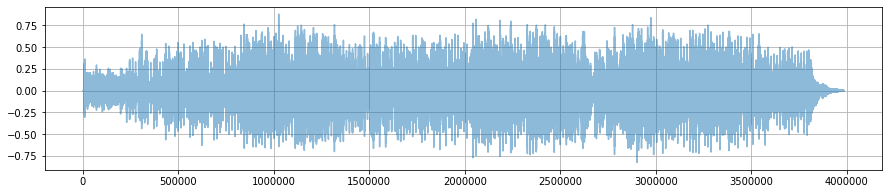

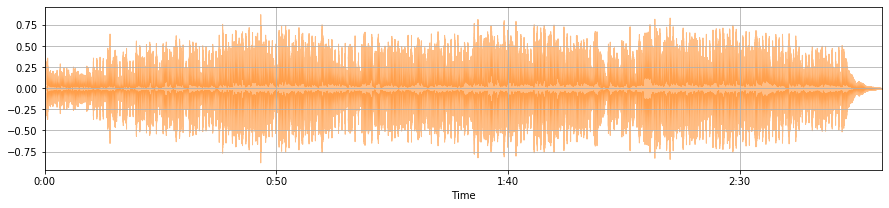

In [37]:
plt.figure(figsize=(15, 3))
plt.plot(df.loc[0, "signal"], color="tab:blue", alpha=0.5)
plt.grid()
plt.show()

plt.figure(figsize=(15, 3))
librosa.display.waveplot(df.loc[0, "signal"], color="tab:orange", alpha=0.5)
plt.grid()
plt.show()

In [58]:
(len(df.loc[0, "signal"]) / 22050), (len(df.loc[3, "signal"]) / 22050)

(180.7209977324263, 200.33020408163264)

In [53]:
dur_1 = librosa.get_duration(df.loc[0, "signal"])
dur_3 = librosa.get_duration(df.loc[3, "signal"])

In [54]:
dur_1, dur_3

(180.7209977324263, 200.33020408163264)

In [64]:
n_fft = 2048
hop_length = 512

stft_1 = librosa.core.stft(df.loc[0, "signal"][:10000], n_fft=n_fft, hop_length=hop_length)
spectrogram_1 = np.abs(stft_1)
log_spectrogram_1 = librosa.amplitude_to_db(spectrogram_1)

stft_3 = librosa.core.stft(df.loc[3, "signal"][:10000], n_fft=n_fft, hop_length=hop_length)
spectrogram_3 = np.abs(stft_3)
log_spectrogram_3 = librosa.amplitude_to_db(spectrogram_3)

In [65]:
log_spectrogram_1.shape, log_spectrogram_3.shape

((1025, 20), (1025, 20))

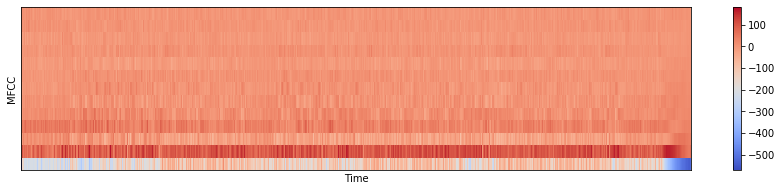

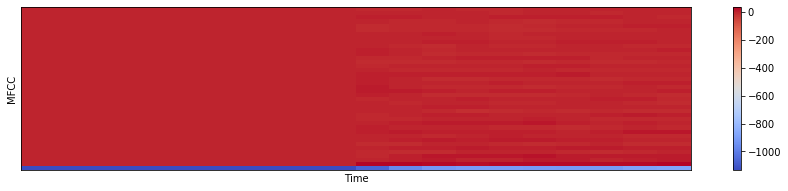

In [68]:
mfcc_1 = librosa.feature.mfcc(df.loc[0, "signal"][:10000], n_fft=2048, hop_length=512, n_mfcc=40)
mfcc_3 = librosa.feature.mfcc(df.loc[3, "signal"][:10000], n_fft=2048, hop_length=512, n_mfcc=40)

plt.figure(figsize=(15, 3))
librosa.display.specshow(mfcc, sr=22040, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

plt.figure(figsize=(15, 3))
librosa.display.specshow(mfcc_3, sr=22040, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

In [69]:
mfcc_1.shape, mfcc_3.shape

((40, 20), (40, 20))

In [ ]:
class SongGenreDataset(Dataset):
    
    def __init__(self, song_dir):
        self.song_dir = song_dir

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        target = self.targets[idx]
        target = np.array(target)
        target = target.astype(np.float64)
        feature = self.features[idx]
        feature = np.array([feature])
        feature = feature.astype(np.float64)
        feature = np.expand_dims(feature, axis=1)
        sample = {
            'feature': torch.from_numpy(feature).float(), 
            'target': torch.from_numpy(target)}
        return sample